In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras import Model, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.applications import MobileNet
from keras.applications.densenet import DenseNet121
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preparation

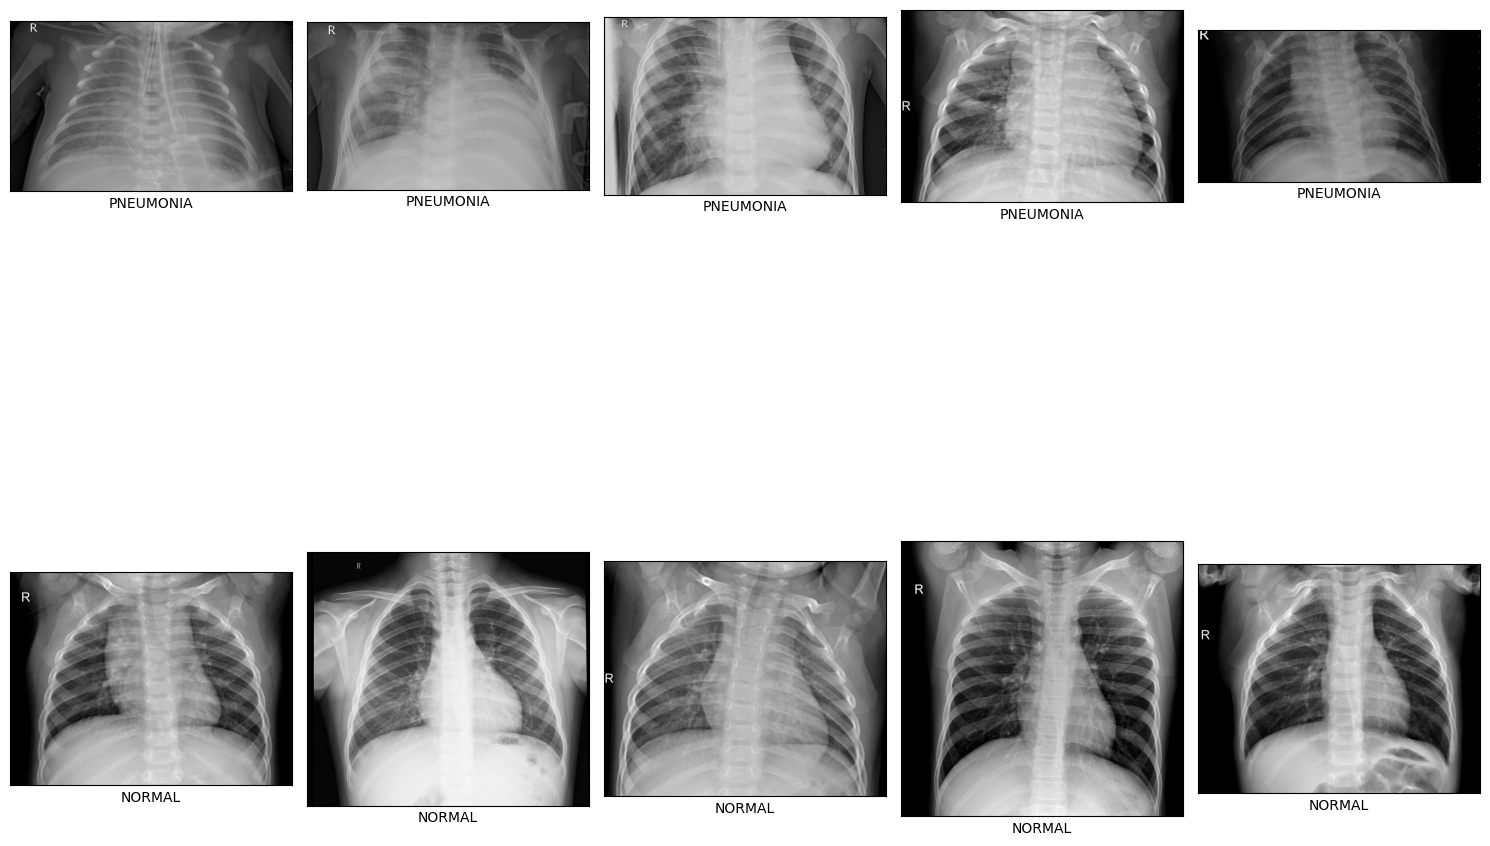

In [8]:
# !kaggle datasets download -d tolgadincer/labeled-chest-xray-images
# !unzip labeled-chest-xray-images.zip

import os 
import shutil

train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

combined_dir = 'chest_xray/dataset'
os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Membuat dictionary untuk menyimpan gambar untuk setiap kelas dalam kata
lung_image = {}

path = "chest_xray/"

# Tentukan path sumber train
path_sub = os.path.join(path, 'dataset')
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 di bawah setiap dari 2 kelas dari data
# Anda akan melihat gambar yang berbeda setiap kali Anda menjalankan sel ini
path_sub = "chest_xray/dataset/"

#Menampilkan 5 gambar secara acak dari setiap kelas data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

# Plot Ditribution

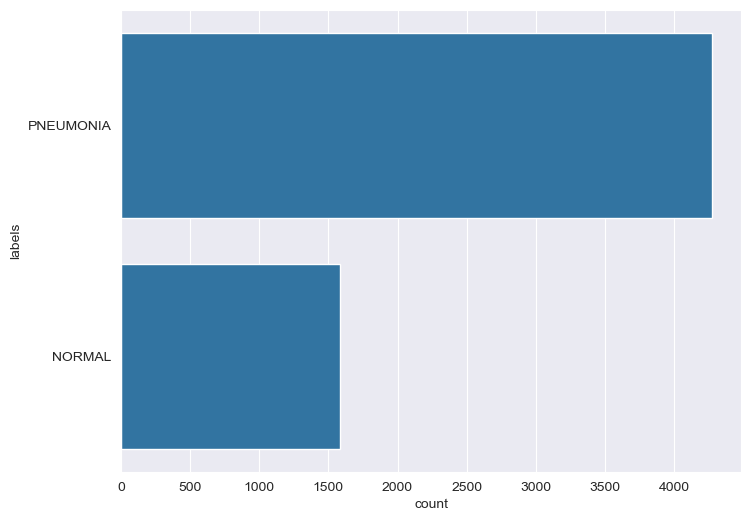

In [9]:
lung_path = "chest_xray/dataset/"

file_names = []
labels = []
full_paths = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_paths.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_names.append(name)

distribution_train = pd.DataFrame({"path": full_paths, "labels": labels, "file_name": file_names})

Label= distribution_train['labels']
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# Data Augmentation

In [10]:
def anticlockwise_rotation(image_array):
    image_array = cv2.cvtColor(image_array, 0)
    image_array = cv2.resize(image_array, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(image_array, angle=sudut)

def clockwise_rotation(image_array):
    image_array = cv2.cvtColor(image_array, 0)
    image_array = cv2.resize(image_array, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(image_array, angle=-sudut)

def flip_up_down(image_array):
    image_array = cv2.cvtColor(image_array, 0)
    image_array = cv2.resize(image_array, (224, 224))
    return np.flipud(image_array)

def add_brightness(image_array):
    image_array = cv2.cvtColor(image_array, 0)
    image_array = cv2.resize(image_array, (224, 224))
    image_array = adjust_gamma(image_array, gamma=0.5, gain=1)
    return image_array

def blur_image(image_array):
    image_array = cv2.cvtColor(image_array, 0)
    image_array = cv2.resize(image_array, (224, 224))
    return cv2.GaussianBlur(image_array, (9, 9), 0)

def sheared(image_array):
    image_array = cv2.cvtColor(image_array, 0)
    image_array = cv2.resize(image_array, (224, 224))
    transform = AffineTransform(shear=0.2)
    sheared_image = warp(image_array, transform, mode='wrap')
    return sheared_image

def warp_shift(img):
    image_array = cv2.cvtColor(img, 0)
    image_array = cv2.resize(image_array, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(image_array, transform, mode='wrap')
    return warp_image    

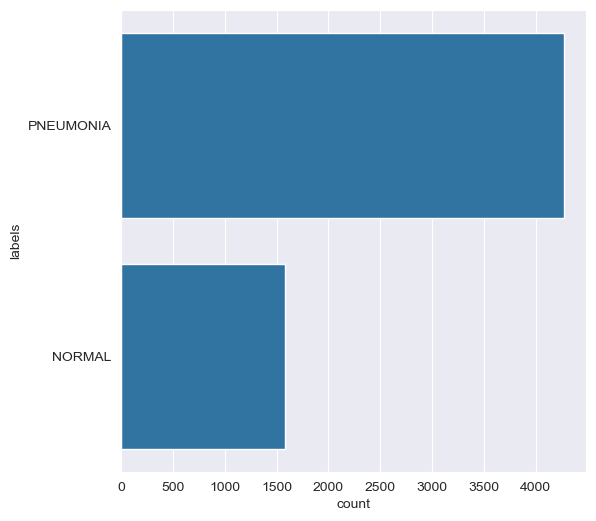

In [12]:
transformations ={ 
    'anticlockwise_rotation': anticlockwise_rotation,
    'clockwise_rotation': clockwise_rotation,
    'flip_up_down': flip_up_down,
    'add_brightness': add_brightness,
    'blur_image': blur_image,
    'sheared': sheared,
    'warp_shift': warp_shift
}

images_path = "chest_xray/dataset/NORMAL/"
augmented_path = "chest_xray/dataset/NORMAL_AUGMENTED/"
images = []

for img_name in os.listdir(images_path):
    img_path = os.path.join(images_path, img_name)
    images.append(img_path)

images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n < transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i = i + 1
    except Exception as e:
        print('could not augment image %s because of error: %s' % (image, e))

lung_path = "chest_xray/dataset"

file_name = []
labels = []
full_paths = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_paths.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_paths, 'file_name': file_name, "labels": labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)


# Data Splitting

In [13]:
my_path = 'chest_xray/dataset'

file_name = []
labels = []
full_paths = []

for path, subdirs, files in os.walk(my_path):
    for name in files:
        full_paths.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path": full_paths, 'file_name':file_name, "labels": labels})

df.groupby(['labels']).size()

labels
NORMAL       1583
PNEUMONIA    4273
dtype: int64

In [ ]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

df_tr = pd.DataFrame({"path": X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({"path": X_test, 'labels': })